# Correlation between isotropy scores and task performane

In [3]:
import json
from pathlib import Path
from pprint import pprint
import numpy as np

from scipy.stats import pearsonr,spearmanr

In [5]:
PROJECT_ROOT = Path('..').resolve()

def sts_result_parser(model_name,task_name,whitening_transformer_name,pooling_mode):
    with open(PROJECT_ROOT / model_name / task_name / whitening_transformer_name /pooling_mode / f'{task_name}.json') as f:
        result = json.load(f)
    return result['test']['cos_sim']['spearman']

def isotropy_result_parser(model_name,whitening_transformer_name,pooling_mode):
    with open(PROJECT_ROOT / model_name / 'isotropy_scores' / whitening_transformer_name /pooling_mode / 'isotropy_scores.json') as f:
        result = json.load(f)
    return result

In [41]:
model_names = ['results/average_word_embeddings_glove.840B.300d','results/GoogleNews-vectors-negative300-torch', 'results/fasttext-en-torch']
TRANSFORM_CONFIG = {
    "normal": {
        "whitening_transformer_class": None,
        "pooling": ["mean"],
    },
    "uniform_whitening": {
        "pooling": ["centering_only", "whitening"],
    },
    "zipfian_whitening": {
        "pooling": ["centering_only", "whitening"],
    },
    "abtp": {
        "pooling": ["component_removal"],
    },
    "sif": {
        "pooling": ["sif_w_component_removal_SICK-R","sif_w_component_removal_STSBenchmark"],
    },
}

results = {
    "STS-B" : {
        "downstream_scores": [],
        "isotropy_scores" : {
            "sym1": [],
            "sym2": [],
            "sym1_uniform": [],
            "sym2_uniform": [],
            "cosine": [],
            "iso_score": [],
        }
    },
    "SICK-R" : {
        "downstream_scores": [],
        "isotropy_scores" : {
            "sym1": [],
            "sym2": [],
            "sym1_uniform": [],
            "sym2_uniform": [],
            "cosine": [],
            "iso_score": [],
        },
    }
}

NAME_DICT = {
    "SICK-R": "SICK-R",
    "STS-B": "STSBenchmark",
}

for downstream_task in results.keys():
    for model_name in model_names:
        for whitening_transformer_name in TRANSFORM_CONFIG.keys():
            if whitening_transformer_name == 'sif':
                ### XXX: carefully yield SIF results
                pooling_mode_ = "sif_w_component_removal"
                for pooling_mode in TRANSFORM_CONFIG[whitening_transformer_name]['pooling']:
                    if "SICK" in downstream_task and "SICK" not in pooling_mode:
                        continue
                    if "STS" in downstream_task and "STS" not in pooling_mode:
                        continue
                    
                    results[downstream_task]['downstream_scores'].append(sts_result_parser(model_name,NAME_DICT[downstream_task],whitening_transformer_name,pooling_mode_))

                    isotropy_scores = isotropy_result_parser(model_name,whitening_transformer_name,pooling_mode)
                    results[downstream_task]['isotropy_scores']['sym1'].append(isotropy_scores['sym1'])
                    results[downstream_task]['isotropy_scores']['sym2'].append(isotropy_scores['sym2'])
                    results[downstream_task]['isotropy_scores']['sym1_uniform'].append(isotropy_scores['sym1_uniform'])
                    results[downstream_task]['isotropy_scores']['sym2_uniform'].append(isotropy_scores['sym2_uniform'])
                    results[downstream_task]['isotropy_scores']['cosine'].append(isotropy_scores['cosine'])
                    results[downstream_task]['isotropy_scores']['iso_score'].append(isotropy_scores['iso_score'])
            else:
                for pooling_mode in TRANSFORM_CONFIG[whitening_transformer_name]['pooling']:
                    results[downstream_task]['downstream_scores'].append(sts_result_parser(model_name,NAME_DICT[downstream_task],whitening_transformer_name,pooling_mode))
                    isotropy_scores = isotropy_result_parser(model_name,whitening_transformer_name,pooling_mode)
                    results[downstream_task]['isotropy_scores']['sym1'].append(isotropy_scores['sym1'])
                    results[downstream_task]['isotropy_scores']['sym2'].append(isotropy_scores['sym2'])
                    results[downstream_task]['isotropy_scores']['sym1_uniform'].append(isotropy_scores['sym1_uniform'])
                    results[downstream_task]['isotropy_scores']['sym2_uniform'].append(isotropy_scores['sym2_uniform'])
                    results[downstream_task]['isotropy_scores']['cosine'].append(isotropy_scores['cosine'])
                    results[downstream_task]['isotropy_scores']['iso_score'].append(isotropy_scores['iso_score'])

corr_results = {}

for downstream_task in results.keys():
    for isotropy_score in results[downstream_task]['isotropy_scores'].keys():
        pearson_corr, _ = pearsonr(results[downstream_task]['downstream_scores'],results[downstream_task]['isotropy_scores'][isotropy_score])
        corr_results[f'{downstream_task}_{isotropy_score}'] = f"{round(pearson_corr*100,2):,.2f}"

In [42]:
pprint(corr_results)

{'SICK-R_cosine': '20.09',
 'SICK-R_iso_score': '18.41',
 'SICK-R_sym1': '60.04',
 'SICK-R_sym1_uniform': '13.26',
 'SICK-R_sym2': '64.60',
 'SICK-R_sym2_uniform': '-8.71',
 'STS-B_cosine': '-6.95',
 'STS-B_iso_score': '0.07',
 'STS-B_sym1': '62.13',
 'STS-B_sym1_uniform': '-21.91',
 'STS-B_sym2': '89.55',
 'STS-B_sym2_uniform': '-22.21'}


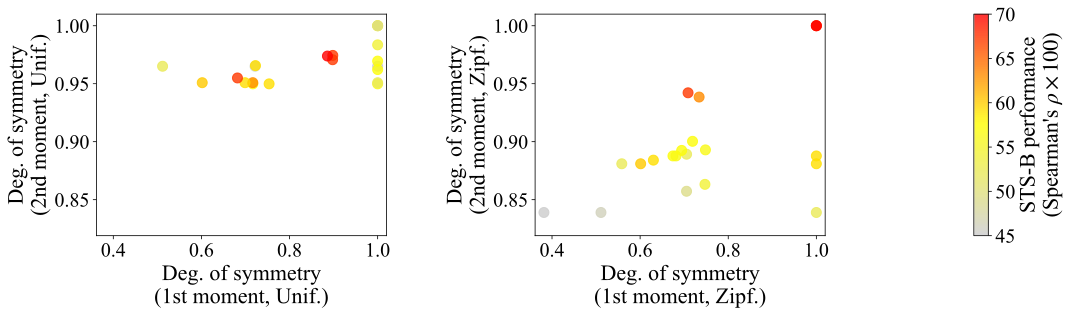

In [45]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
# backend SVG
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['text.usetex'] = False
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm}')
# weight
# latex change the font weight

task_name = "STS-B"
res = results[task_name]

%config InlineBackend.figure_formats = ['svg']

# Create a custom colormap: white to red
colors = [(0.8, 0.8, 0.8), (1, 1, 0), (1, 0, 0)] # white to red
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'white_to_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

sym1 = res['isotropy_scores']['sym1']
sym2 = res['isotropy_scores']['sym2']
sym1_uniform = res['isotropy_scores']['sym1_uniform']
sym2_uniform = res['isotropy_scores']['sym2_uniform']
task_scores = list(map(lambda x: round(x, 2) * 100, res['downstream_scores']))

# Create scatter plot
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.75)


ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
cax = fig.add_subplot(gs[2])

label_fontsize = 22
tick_fontsize = 20
cbar_fontsize = 22
buffer = 0.02
xlims = [min(min(sym1), min(sym1_uniform)) - buffer, 1.0 + buffer]
ylims = [min(min(sym2), min(sym2_uniform)) - buffer, 1.0 + buffer-0.01]

# Scatter plot for the left subplot
scatter1 = ax1.scatter(sym1_uniform, sym2_uniform, c=task_scores, cmap=cm, alpha=0.8, s=100)
ax1.set_xlabel("""Deg. of symmetry\n(1st moment, Unif.)""", fontsize=label_fontsize)
ax1.set_ylabel("""Deg. of symmetry\n(2nd moment, Unif.)""", fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)

# Scatter plot for the right subplot
scatter2 = ax2.scatter(sym1, sym2, c=task_scores, cmap=cm, alpha=0.8, s=100)
ax2.set_xlabel("""Deg. of symmetry\n(1st moment, Zipf.)""", fontsize=label_fontsize)
ax2.set_ylabel("""Deg. of symmetry\n(2nd moment, Zipf.)""", fontsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)

# Create a colorbar
cbar = plt.colorbar(scatter2, cax=cax)
cbar.set_label(r"""STS-B performance
(Spearman's $\rho \times 100$)""", fontsize=cbar_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# Show plot
plt.savefig('figs/correlation_3dplot.pdf',bbox_inches='tight')
plt.show()

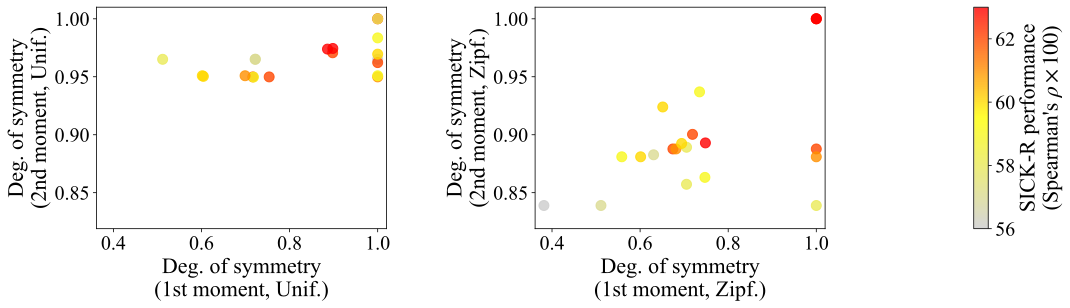

In [46]:
# Assuming `results` is already defined somewhere in your code
# Uncomment the following line if `results` is not defined
# results = your_data_loading_function()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
# backend SVG
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['text.usetex'] = False
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm}')
# weight
# latex change the font weight

task_name = "SICK-R"
res = results[task_name]

%config InlineBackend.figure_formats = ['svg']

# Create a custom colormap: white to red
colors = [(0.8, 0.8, 0.8), (1, 1, 0), (1, 0, 0)] # white to red
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'white_to_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

sym1 = res['isotropy_scores']['sym1']
sym2 = res['isotropy_scores']['sym2']
sym1_uniform = res['isotropy_scores']['sym1_uniform']
sym2_uniform = res['isotropy_scores']['sym2_uniform']
task_scores = list(map(lambda x: round(x, 2) * 100, res['downstream_scores']))

# Create scatter plot
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.75)


ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
cax = fig.add_subplot(gs[2])

label_fontsize = 22
tick_fontsize = 20
cbar_fontsize = 22
buffer = 0.02
xlims = [min(min(sym1), min(sym1_uniform)) - buffer, 1.0 + buffer]
ylims = [min(min(sym2), min(sym2_uniform)) - buffer, 1.0 + buffer-0.01]

# Scatter plot for the left subplot
scatter1 = ax1.scatter(sym1_uniform, sym2_uniform, c=task_scores, cmap=cm, alpha=0.8, s=100)
ax1.set_xlabel("""Deg. of symmetry\n(1st moment, Unif.)""", fontsize=label_fontsize)
ax1.set_ylabel("""Deg. of symmetry\n(2nd moment, Unif.)""", fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)

# Scatter plot for the right subplot
scatter2 = ax2.scatter(sym1, sym2, c=task_scores, cmap=cm, alpha=0.8, s=100)
ax2.set_xlabel("""Deg. of symmetry\n(1st moment, Zipf.)""", fontsize=label_fontsize)
ax2.set_ylabel("""Deg. of symmetry\n(2nd moment, Zipf.)""", fontsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)

# Create a colorbar
cbar = plt.colorbar(scatter2, cax=cax)
cbar.set_label(r"""SICK-R performance
(Spearman's $\rho \times 100$)""", fontsize=cbar_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# Show plot
plt.savefig('figs/correlation_3dplot_sick-r.pdf',bbox_inches='tight')
plt.show()